In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

# module containing the main functions
import utils as ut
import utils_phase_diagr as ut_pd

# Phase diagram varying $\tau_{crit}$ and $\alpha_0$ 

In [2]:
# Parameters

# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm()

# Integration parameters
t_steps, dt, traj_steps = 100000, 'adapt', 30

# Memory stopping condition parameter
theta = 0.2  

# Fraction of ensambles with maximum to determine the non-monotoncity
no_max_perc = 0.9

# Minimal expansion factor
min_expans = 1.5

# Number of realizations in an ensemble
R = 200

In [ ]:
# Computing the diagram (long time). Results saved in 'out_data/<name>.pkl'

# Defining the grid tau critical - alpha0
tau_crits = np.logspace(-2, 0.5, 3)
alpha0s = np.logspace(-7, -1, 3)
sh = (len(tau_crits), len(alpha0s))

# Initializing matrices to store results
x_max_mat, y_max_mat, simps_mat = np.zeros(sh), np.zeros(sh), np.zeros(sh)
Ttot_mat, outcome_mat, frac_nomax_mat = np.zeros(sh), np.zeros(sh, dtype='U10'), np.zeros(sh)
av_times_mat = np.zeros(sh)
progress = tqdm(total=len(tau_crits)*len(alpha0s))

# Computing the phase diagram
for i, tau_c in enumerate(tau_crits):
    for j, alpha0 in enumerate(alpha0s):
        data = ut_pd.generate_ensamble(R, tau_samp, t_steps, dt, traj_steps, theta, print_progress=False, alpha0=alpha0, tau_crit=tau_c)
        taus_mat, Tfreqs_mat, T_tot_mat, times_mat = data
        x_max, y_max, n_x_max, outcome = ut_pd.find_max(taus_mat, Tfreqs_mat)
        x_max_mat[i,j], y_max_mat[i,j], av_times_mat[i,j] = x_max, y_max, np.mean([t[-1] for t in times_mat])
        outcome_mat[i,j], frac_nomax_mat[i,j] = outcome, (R - n_x_max) / R
        Ttot = np.mean([np.max(Ttot) for Ttot in T_tot_mat])
        simps_mat[i,j], Ttot_mat[i,j] = ut_pd.compute_inv_simps(Tfreqs_mat), Ttot
        progress.update(1)

# Saving data
name = 'phase_diagram_tc_a0_' + str(len(tau_crits)*len(alpha0s))
with open(f'out_data/phase_diagram/{name}.pkl', 'wb') as f:
    pickle.dump((tau_crits, alpha0s, x_max_mat, y_max_mat, simps_mat, Ttot_mat, outcome_mat, frac_nomax_mat), f)

# Saving parameters
pars = ut.TT_params([1])  # just to have access to default parameters
tau_samp = ut.tau_sampler_lognorm() 
other_params = {'theta_stop': theta, 'no_max_perc': no_max_perc, 'min_expans': min_expans, 'R' : R}
other_params = {**tau_samp.get_pars(), **other_params}
pars.print_on_file('out_data/phase_diagram/', name, other_params)

 22%|██▏       | 2/9 [00:22<01:17, 11.12s/it]/home/andrea/Scrivania/TT-inhibition/utils_phase_diagr.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  inv_simps = np.array([1 / np.sum(freqs**2) for freqs in T_freqs_mat])
100%|██████████| 9/9 [08:29<00:00, 76.11s/it]

In [3]:
name = 'phase_diagram_tc_a0_900'

# Importing the parameters
params = pd.read_csv(f'out_data/phase_diagram/{name}.tsv', sep='\t', header=None, index_col=0)[1].to_dict()

# Importing the data and applying thresholds for plotting
data = pickle.load(open(f'out_data/phase_diagram/{name}.pkl', 'rb'))
tau_crits, alpha0s, x_max_mat, y_max_mat, simps_mat, Ttot_mat, outcome_mat, frac_nomax_mat = data

# Appling the thresholds
outcome_mat[frac_nomax_mat > no_max_perc] = 'no_maximum'
outcome_mat[Ttot_mat < min_expans * tau_samp.n_samples] = 'extinct'

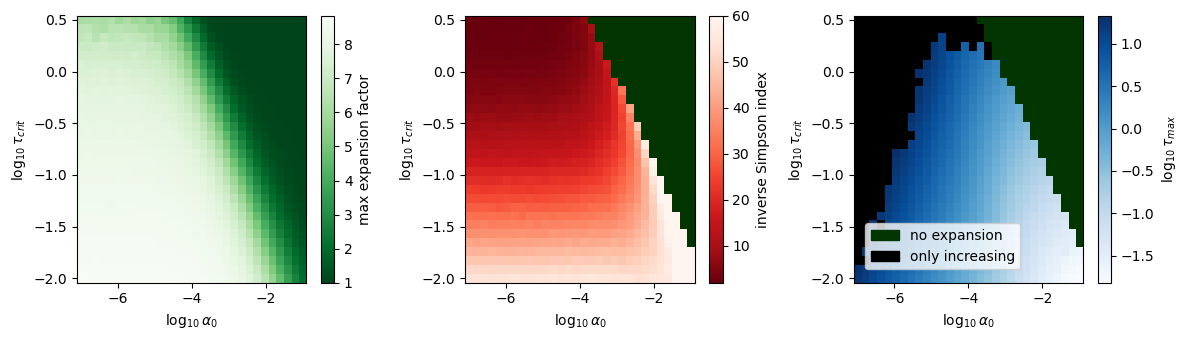

In [5]:
# Plotting the phase diagrams

fig, (ax3, ax2, ax1) = plt.subplots(1, 3, figsize=(12,3.5))

xs, ys = np.log10(alpha0s), np.log10(tau_crits)
extent = (xs[0] - (xs[1]-xs[0])/2, xs[-1] + (xs[1]-xs[0])/2, ys[0] - (ys[1]-ys[0])/2, ys[-1] + (ys[1]-ys[0])/2)

aux_mat = np.where(outcome_mat == 'maximum', x_max_mat, float('nan'))
ax1.imshow(aux_mat[::-1], extent=extent, aspect='auto', cmap='Blues')
ax1 = ut_pd.add_phases(ax1, outcome_mat, extent, legend=True)
ax1.set_xlabel(r'$\log_{10}\alpha_{0}$')
ax1.set_ylabel(r'$\log_{10}\tau_{crit}$')
cb1 = fig.colorbar(ax1.images[0], ax=ax1)
cb1.set_label(r'$\log_{10}\tau_{max}$')

aux_mat = np.where(outcome_mat != 'extinct', simps_mat, float('nan'))
ax2.imshow(aux_mat[::-1], extent=extent, aspect='auto', vmax=60, cmap='Reds_r')
ax2 = ut_pd.add_phases(ax2, outcome_mat, extent, add_increasing=False)
ax2.set_xlabel(r'$\log_{10}\alpha_{0}$')
ax2.set_ylabel(r'$\log_{10}\tau_{crit}$')  
cb2 = fig.colorbar(ax2.images[0], ax=ax2)
cb2.set_label('inverse Simpson index')

ax3.imshow(Ttot_mat[::-1] / params['n_samples'], extent=extent, aspect='auto', cmap='Greens_r')
ax3.set_xlabel(r'$\log_{10}\alpha_{0}$')
ax3.set_ylabel(r'$\log_{10}\tau_{crit}$')  
cb3 = fig.colorbar(ax3.images[0], ax=ax3)
cb3.set_label('max expansion factor')

plt.tight_layout()

plt.savefig('plots/phase_diagram/'+name+'.svg', dpi=200, facecolor='w')